In [ ]:
pip install keras-pos-embd

  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp37-none-any.whl size=7554 sha256=392447de50de591fac45bd22a4ae63ae9b1c232d6cb9351ea7be4abfce50c920
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
Successfully built keras-pos-embd


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import itertools

%matplotlib inline
import matplotlib.pyplot as plt # for plottiing
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
layers = keras.layers
models = keras.models
from keras_pos_embd import TrigPosEmbedding

# This code was tested with TensorFlow v1.8
print("You have TensorFlow version", tf.__version__)


You have TensorFlow version 2.4.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv (r'/content/drive/MyDrive/twitter data/train1 (1).csv') # ram
#data = pd.read_csv (r'/content/drive/My Drive/text_classification/archive/train1.csv')  #mukul

# data = pd.read_csv (r'/content/train1.csv')  #mukul

In [ ]:
data.head()

,Unnamed: 0,Unnamed: 0.1,tweet_id,text,tweet_city,tweet_latitude,tweet_longitude,city,code,country
0,0,0,323096393520668672,"Whenever you feel weak, remember those who mad...",owerri-28-ng,5.485230,7.006620,owerri,28,ng
1,1,1,371125032858038272,Don't confuse your path with your destination....,mumbai-16-in,19.142740,72.824789,mumbai,16,in
2,2,2,412300993762578432,@j3nnifer_Try0n @HaileyGerlach I don't wanna go!,fargo-nd017-us,46.862505,-96.845927,fargo,nd017,us
3,3,3,391134904115007488,"""@ShieldWomen: Wish for it or work for it? #Do...",johannesburg-06jhb-za,-26.074659,27.980324,johannesburg,06jhb,za
4,4,4,543696911262564352,@oxfordblue1968 @RATHBushcraft yep all our twe...,dewsbury-eng00-gb,53.629186,-1.635556,dewsbury,eng00,gb


In [ ]:
data['city'].value_counts()

jakarta           169
city of london    100
los angeles        98
bandung            89
chicago            61
                 ... 
dusseldorf          1
high wycombe        1
teluk intan         1
albacete            1
el paso             1
Name: city, Length: 980, dtype: int64

In [ ]:
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 4593
Test size: 1149


In [ ]:
def train_test_split(data, train_size):
    train = data[:train_size]
    test = data[train_size:]
    return train, test

In [ ]:
train_cat, test_cat = train_test_split(data['city'], train_size)
train_country_cat, test_country_cat = train_test_split(data['country'], train_size)
train_text, test_text = train_test_split(data['text'], train_size)

In [ ]:
max_words = 1000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, 
                                              char_level=False,oov_token='UNK')
char_tokenize = keras.preprocessing.text.Tokenizer(num_words=None, 
                                              char_level=True,oov_token='UNK')

In [ ]:
tokenize.fit_on_texts(train_text) # fit tokenizer to our training text data
char_tokenize.fit_on_texts(train_text)
x_char_train = char_tokenize.texts_to_sequences(train_text)
x_char_test = char_tokenize.texts_to_sequences(test_text)
x_train = tokenize.texts_to_sequences(train_text)
x_test = tokenize.texts_to_sequences(test_text)
# print(x_train.shape)
# print(tokenize.word_index)
print(tokenize.document_count)
print(train_text)
print(x_train[0])
print(x_char_train[0])
maxlen = max([len(x) for x in x_train])
print(maxlen)

4593
0       Whenever you feel weak, remember those who mad...
1       Don't confuse your path with your destination....
2        @j3nnifer_Try0n @HaileyGerlach I don't wanna go!
3       "@ShieldWomen: Wish for it or work for it? #Do...
4       @oxfordblue1968 @RATHBushcraft yep all our twe...
                              ...                        
4588                                                  806
4589    @a_rahman101 I'm fine ALHUMDULILAH! why don't ...
4590         Listening to muse in the car with the father
4591    Don't be afraid of change. You may end up losi...
4592    Take me away over the hills and far away... ht...
Name: text, Length: 4593, dtype: object
[1, 10, 153, 1, 421, 322, 96, 193, 10, 1, 11, 1, 10, 173, 7, 1, 454, 421, 322, 96, 537, 14, 10]
[21, 11, 4, 8, 4, 27, 4, 10, 2, 17, 6, 16, 2, 24, 4, 4, 12, 2, 21, 4, 5, 25, 35, 2, 10, 4, 14, 4, 14, 22, 4, 10, 2, 3, 11, 6, 9, 4, 2, 21, 11, 6, 2, 14, 5, 15, 4, 2, 17, 6, 16, 2, 9, 3, 10, 6, 8, 19, 2, 5, 8, 15, 2, 21, 1

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# pad sequences 
max_sequence_len = 30
x_train = np.array(pad_sequences(x_train, maxlen=max_sequence_len, padding='post'))
# pad sequences 
max_sequence_len = 140
x_char_train = np.array(pad_sequences(x_char_train, maxlen=max_sequence_len, padding='post'))

max_sequence_len = 140
x_char_test = np.array(pad_sequences(x_char_test, maxlen=max_sequence_len, padding='post'))
max_sequence_len = 30
x_test = np.array(pad_sequences(x_test, maxlen=max_sequence_len, padding='post'))

In [ ]:
class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [ ]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoderExt()
encoder.fit(train_cat)
y_train = encoder.transform(train_cat)
y_test = encoder.transform(test_cat)

encoder_country = LabelEncoderExt()
encoder_country.fit(train_country_cat)
y_country_train = encoder_country.transform(train_country_cat)
y_country_test = encoder_country.transform(test_country_cat)

In [ ]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

num_classes_country = np.max(y_country_train) + 1
y_country_train = keras.utils.to_categorical(y_country_train, num_classes_country)
y_country_test = keras.utils.to_categorical(y_country_test, num_classes_country)

In [ ]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
y_train = np.array(y_train)
x_train = np.array(x_train)
# x_train = np.array(x_train)
# x_train = np.array(x_train)
print('x_train shape:', x_train.shape, x_train.dtype)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('y_train shape:', y_country_train.shape)
print('y_test shape:', y_country_test.shape)
print(num_classes,num_classes_country)
# x_test = tf.convert_to_tensor(x_countaintrain)

x_train shape: (4593, 30) int32
x_test shape: (1149, 30)
y_train shape: (4593, 929)
y_test shape: (1149, 929)
y_train shape: (4593, 91)
y_test shape: (1149, 91)
929 91


In [ ]:
#make the model
#position encoding
#creating model as given in our paper
#  num_words = 1000

drop = 0.1
word_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
char_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
d = 200    #dimension of a word
# Embed each word in the title into a 64-dimensional vector
word_features = layers.Embedding(1000, d)(word_input)

word_features = TrigPosEmbedding(
    output_dim=d,                      # The dimension of embeddings.
    mode=TrigPosEmbedding.MODE_ADD,  # Use `expand` mode
)(word_features)
# word_features = layers.add([word_features,pos_encoding])
print(word_features.shape)
#experiment for word-level convolution

#word convolution for characters filters=100 kernel=3
word_res_conv = tf.keras.layers.Conv1D(200, 3, activation='relu',input_shape=(None,128))(word_features)
print(res_conv.shape, " res conv shape")

#word max pooling layer after conv1D
word_res_pool = tf.keras.layers.MaxPooling1D(pool_size=3,strides=1, padding='valid')(word_res_conv)
print(res_pool.shape, " res pool shape")
#

# CHARS getting character encoding here instead for now only using words
char_features = layers.Embedding(1000, 100)(char_input)
print(char_features.shape, " char features")

#CHARS convolution for characters filters=100 kernel=3
res_conv = tf.keras.layers.Conv1D(64, 3, activation='relu',input_shape=(None,128))(char_features)
print(res_conv.shape, " res conv shape")

#CHARS max pooling layer after conv1D
res_pool = tf.keras.layers.MaxPooling1D(pool_size=3,strides=1, padding='valid')(res_conv)
print(res_pool.shape, " res pool shape")

#############################################
# res_conv = tf.keras.layers.Conv1D(64, 4, activation='relu',input_shape=(None,128))(res_pool)
# print(res_conv.shape, " res conv shape")

# #CHARS max pooling layer after conv1D
# res_pool = tf.keras.layers.MaxPooling1D(pool_size=3,strides=1, padding='valid')(res_conv)
# print(res_pool.shape, " res pool shape")

# res_conv = tf.keras.layers.Conv1D(64, 5, activation='relu',input_shape=(None,128))(res_pool)
# print(res_conv.shape, " res conv shape")

# #CHARS max pooling layer after conv1D
# res_pool = tf.keras.layers.MaxPooling1D(pool_size=3,strides=1, padding='valid')(res_conv)
# print(res_pool.shape, " res pool shape")

#############################################

#CHARS two multihead self-attention folloowed by feed forward neural network
multi = layers.MultiHeadAttention(num_heads=8,key_dim=2) 

char_features = multi(res_pool, res_pool)  # respool used two times for self-attention
print(word_features.shape)
p = 64
char_features1 = layers.Dense(4*p, activation='relu')(char_features) # feed forward network layer1
char_features1 = layers.Dense(p, activation='relu')(char_features1) # feed forward network layer2 
char_features = layers.add([char_features, char_features1])  # residual layer

print(char_features.shape, " char features shape")
multi = layers.MultiHeadAttention(num_heads=8,key_dim=2)
char_features = multi(char_features, char_features)  
char_features1 = layers.Dense(4*p, activation='relu')(char_features) # feed forward network layer1
char_features1 = layers.Dense(p, activation='relu')(char_features1) # feed forward network layer2 
char_features = layers.add([char_features, char_features1])  # residual layer
multi = layers.MultiHeadAttention(num_heads=8,key_dim=2) 
#layer added
char_features = multi(char_features, char_features)  # respool used two times for self-attention
print(word_features.shape)
p = 64
char_features1 = layers.Dense(4*p, activation='relu')(char_features) # feed forward network layer1
char_features1 = layers.Dense(p, activation='relu')(char_features1) # feed forward network layer2 
char_features = layers.add([char_features, char_features1])  # residual layer

char_features = tf.reduce_sum(char_features, 1) #converts word matrix to a vector of dimension f 
print(char_features.shape, " char features shape")

#changes made
multi = layers.MultiHeadAttention(num_heads=10,key_dim=2) 

word_features = multi(word_res_pool, word_res_pool)  # respool used two times for self-attention
print(word_features.shape)
word_features1 = layers.Dense(4*d, activation='relu')(word_features) # feed forward network layer1
word_features1 = layers.Dense(d, activation='relu')(word_features1) # feed forward network layer2 
word_features = layers.add([word_features, word_features1])  # residual layer
#
#WORDS stack of two multihead self-attention with position-wise feed forward network
multi = layers.MultiHeadAttention(num_heads=10,key_dim=2) 

word_features = multi(word_features, word_features)  
print(word_features.shape)

word_features1 = layers.Dense(4*d, activation='relu')(word_features) # feed forward network layer1
word_features1 = layers.Dense(d, activation='relu')(word_features1) # feed forward network layer2 
word_features = layers.add([word_features, word_features1])  # residual layer

multi = layers.MultiHeadAttention(num_heads=10,key_dim=2) 

word_features = multi(word_features, word_features) 
print(word_features.shape)

word_features1 = layers.Dense(4*d, activation='relu')(word_features) # feed forward network layer1
word_features1 = layers.Dense(d, activation='relu')(word_features1) # feed forward network layer2 
word_features = layers.add([word_features, word_features1])  # residual layer
#layer added
multi = layers.MultiHeadAttention(num_heads=10,key_dim=2) 

word_features = multi(word_features, word_features)  
print(word_features.shape)

word_features1 = layers.Dense(4*d, activation='relu')(word_features) # feed forward network layer1
word_features1 = layers.Dense(d, activation='relu')(word_features1) # feed forward network layer2 
word_features = layers.add([word_features, word_features1])  # residual layer

word_features = tf.reduce_sum(word_features, 1) #converts word matrix to a vector of dimension d  #equation 12

x = layers.concatenate([word_features, char_features]) # concatenate word vector and char vector
print(x.shape," x shape")
dropout = layers.Dropout(drop)(x)
city_pred = layers.Dense(num_classes, name="city",activation="softmax")(x)   #change value of 2 to number of possible cities
# city_pred = tf.keras.layers.Softmax(city_pred)
country_pred = layers.Dense(num_classes_country, name="country",activation="softmax")(x)  #change value of 2 to number of possible countries
# country_pred = tf.keras.layers.Softmax(country_pred)
model = keras.Model(inputs=[word_input,char_input],
                   outputs=[city_pred, country_pred],
)
print(model.summary())

(None, None, 200)
(None, None, 64)  res conv shape
(None, None, 64)  res pool shape
(None, None, 100)  char features
(None, None, 64)  res conv shape
(None, None, 64)  res pool shape
(None, None, 200)
(None, None, 64)  char features shape
(None, None, 200)
(None, 64)  char features shape
(None, None, 200)
(None, None, 200)
(None, None, 200)
(None, None, 200)
(None, 264)  x shape
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, None, 200)    200000      title[0][0]                      
__________________________________________________________________________________________________
trig_po

In [ ]:
[print("i ",i.shape, i.dtype) for i in model.inputs]
[print("o ",o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

i  (None, None) <dtype: 'float32'>
i  (None, None) <dtype: 'float32'>
o  (None, 929) <dtype: 'float32'>
o  (None, 91) <dtype: 'float32'>
title [(None, None)] float32
embedding_14 (None, None) float32
trig_pos_embedding_7 (None, None, 200) float32
conv1d_10 (None, None, 200) float32
max_pooling1d_10 (None, None, 200) float32
multi_head_attention_35 (None, None, 200) float32
body [(None, None)] float32
dense_70 (None, None, 200) float32
embedding_15 (None, None) float32
dense_71 (None, None, 800) float32
conv1d_11 (None, None, 100) float32
add_35 [(None, None, 200), (None, None, 200)] float32
max_pooling1d_11 (None, None, 64) float32
multi_head_attention_36 (None, None, 200) float32
multi_head_attention_32 (None, None, 64) float32
dense_72 (None, None, 200) float32
dense_64 (None, None, 64) float32
dense_73 (None, None, 800) float32
dense_65 (None, None, 256) float32
add_36 [(None, None, 200), (None, None, 200)] float32
add_32 [(None, None, 64), (None, None, 64)] float32
multi_head_atten

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

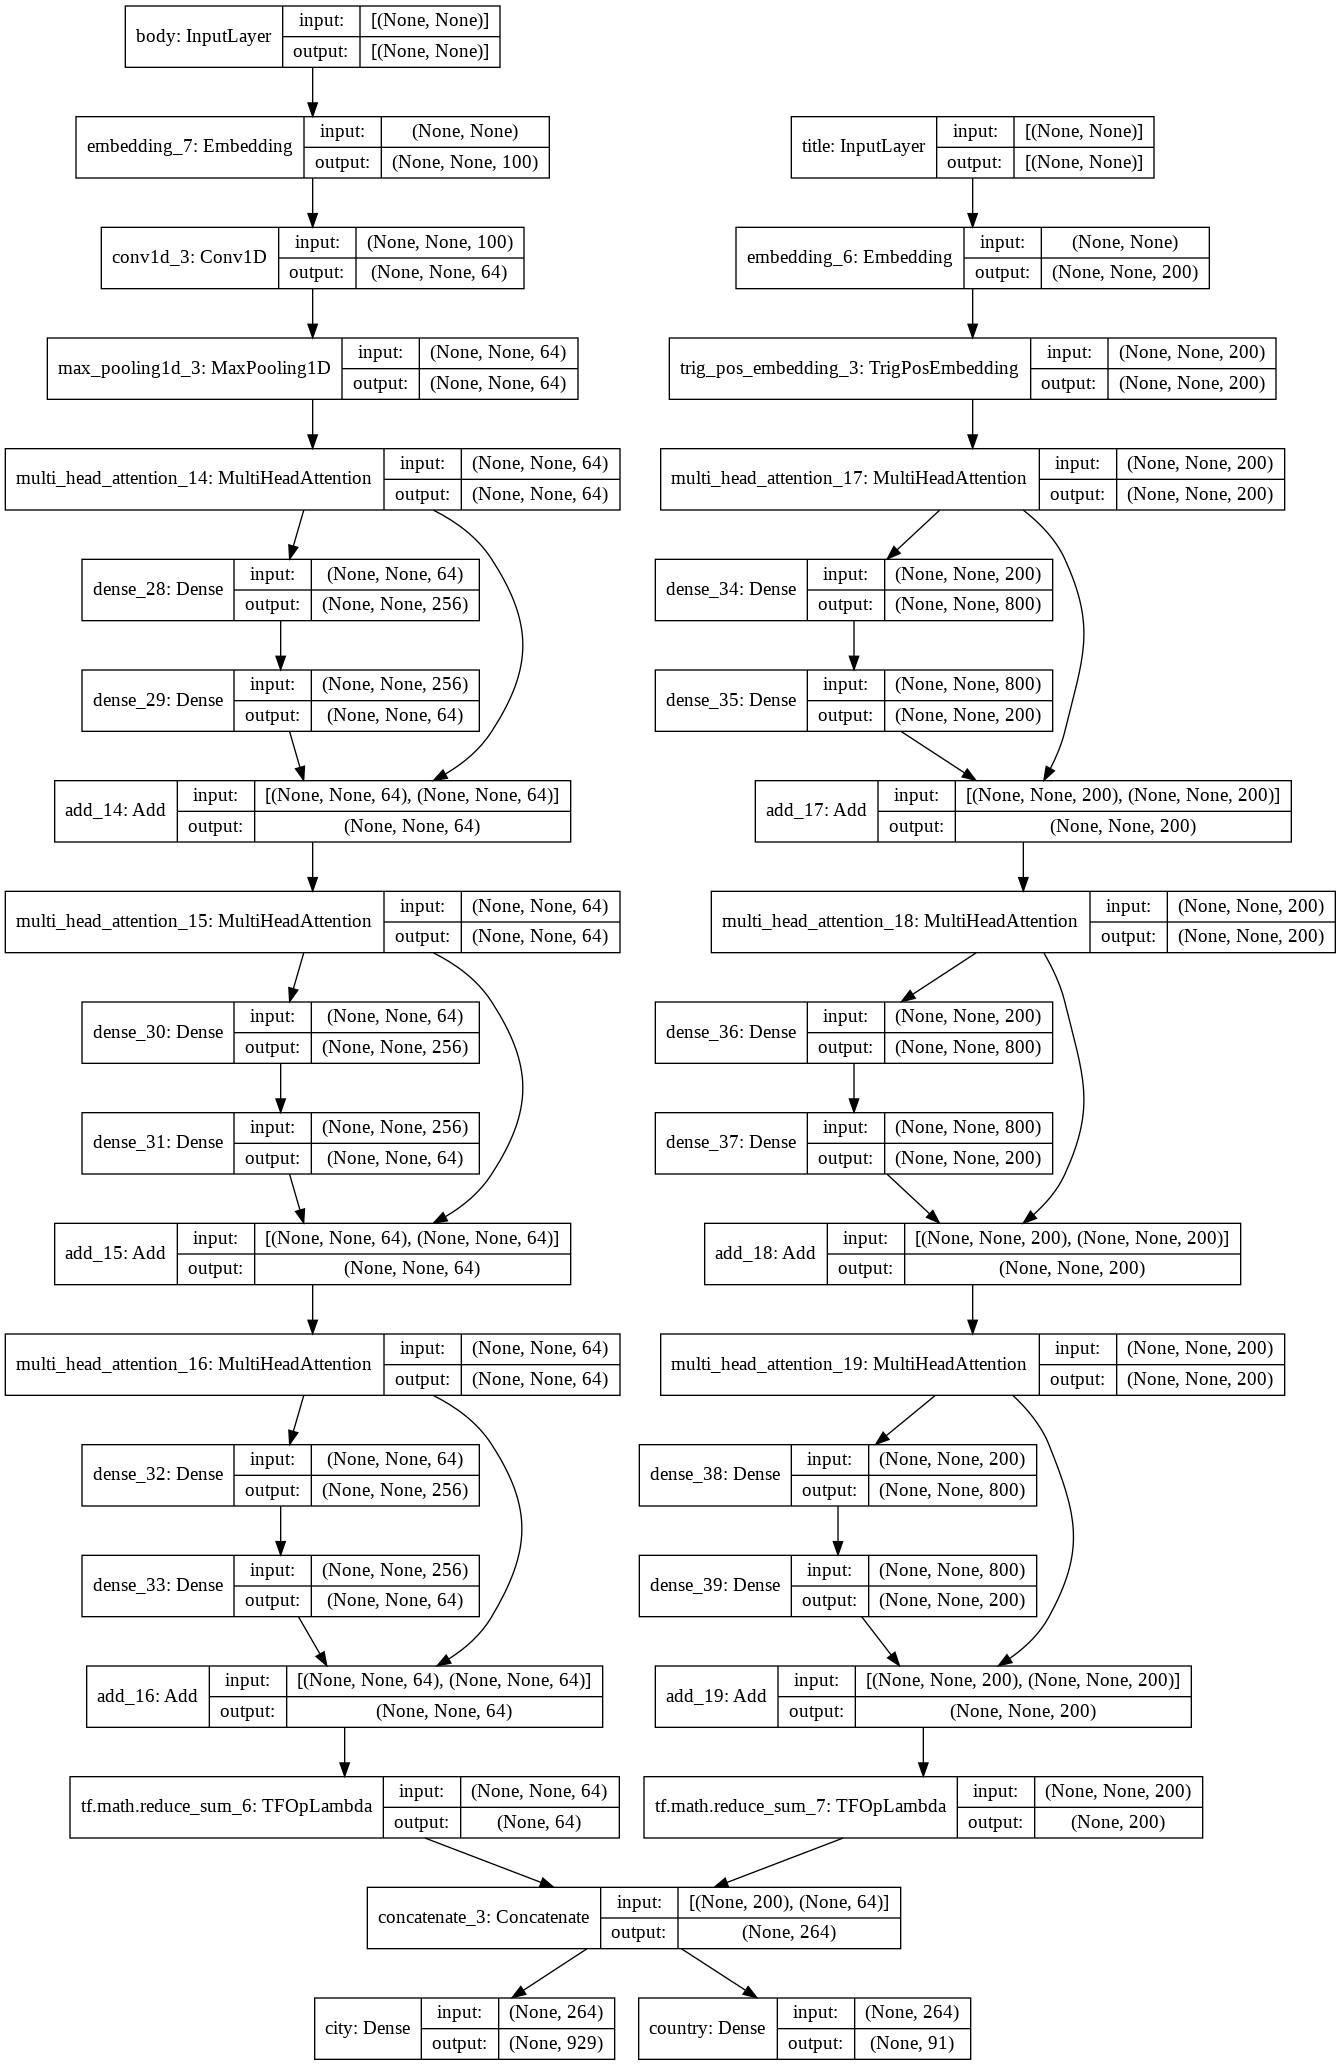

In [ ]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(0.0005),
    loss={
        "city": keras.losses.CategoricalCrossentropy(from_logits=True),
        "country": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 1.0],
    metrics = ['accuracy']
)

In [ ]:
print(y_country_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
history = model.fit(
    {"title": x_train,"body":x_char_train},
    {"city": y_train,"country":y_country_train},  # y_train in front of country should be changed 
    epochs=15,
    batch_size=512,
    verbose=1
) 


Epoch 1/15
9/9 [==============================] - 108s 11s/step - loss: 10.6785 - city_loss: 6.8209 - country_loss: 3.8576 - city_accuracy: 3.2495e-04 - country_accuracy: 0.2977
Epoch 2/15
9/9 [==============================] - 102s 11s/step - loss: 9.3523 - city_loss: 6.6672 - country_loss: 2.6851 - city_accuracy: 0.0268 - country_accuracy: 0.3350
Epoch 3/15
9/9 [==============================] - 105s 12s/step - loss: 8.9573 - city_loss: 6.4095 - country_loss: 2.5477 - city_accuracy: 0.0303 - country_accuracy: 0.3988
Epoch 4/15
9/9 [==============================] - 104s 12s/step - loss: 8.7889 - city_loss: 6.2796 - country_loss: 2.5093 - city_accuracy: 0.0282 - country_accuracy: 0.3984
Epoch 5/15
9/9 [==============================] - 105s 12s/step - loss: 8.7496 - city_loss: 6.2712 - country_loss: 2.4784 - city_accuracy: 0.0263 - country_accuracy: 0.4060
Epoch 6/15
9/9 [==============================] - 104s 12s/step - loss: 8.7230 - city_loss: 6.2564 - country_loss: 2.4666 - city_a

In [ ]:
# Evaluate the accuracy of our trained model
score = model.evaluate({"title": x_test,"body":x_char_test},
    {"city": y_test,"country": y_country_test}, batch_size=512, verbose=1)
print('Test loss:', score[0])
print('Test city accuracy:', score[3]*100)
print('Test country accuracy:', score[4]*100)

3/3 [==============================] - 10s 2s/step - loss: 8.7299 - city_loss: 6.3635 - country_loss: 2.3665 - city_accuracy: 0.0400 - country_accuracy: 0.4073
Test loss: 8.729947090148926
Test city accuracy: 4.0034811943769455
Test country accuracy: 40.731069445610046


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  # plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


print(history.history.keys())

dict_keys(['loss', 'city_loss', 'country_loss', 'city_accuracy', 'country_accuracy'])


In [ ]:
#  num_words = 1000

drop = 0.3
word_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
char_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
d = 200    #dimension of a word
# Embed each word in the title into a 64-dimensional vector
word_features = layers.Embedding(1000, d)(word_input)

word_features = TrigPosEmbedding(
    output_dim=d,                      # The dimension of embeddings.
    mode=TrigPosEmbedding.MODE_ADD,  # Use `expand` mode
)(word_features)
# word_features = layers.add([word_features,pos_encoding])
print(word_features.shape)

# CHARS getting character encoding here instead for now only using words
char_features = layers.Embedding(1000, 100)(char_input)
print(char_features.shape, " char features")

#CHARS convolution for characters filters=100 kernel=3
res_conv = tf.keras.layers.Conv1D(64, 3, activation='relu',input_shape=(None,128))(char_features)
print(res_conv.shape, " res conv shape")

#CHARS max pooling layer after conv1D
res_pool = tf.keras.layers.MaxPooling1D(pool_size=3,strides=1, padding='valid')(res_conv)
print(res_pool.shape, " res pool shape")

#############################################
# res_conv = tf.keras.layers.Conv1D(64, 4, activation='relu',input_shape=(None,128))(res_pool)
# print(res_conv.shape, " res conv shape")

# #CHARS max pooling layer after conv1D
# res_pool = tf.keras.layers.MaxPooling1D(pool_size=3,strides=1, padding='valid')(res_conv)
# print(res_pool.shape, " res pool shape")

# res_conv = tf.keras.layers.Conv1D(64, 5, activation='relu',input_shape=(None,128))(res_pool)
# print(res_conv.shape, " res conv shape")

# #CHARS max pooling layer after conv1D
# res_pool = tf.keras.layers.MaxPooling1D(pool_size=3,strides=1, padding='valid')(res_conv)
# print(res_pool.shape, " res pool shape")

#############################################

res = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))(res_pool)
res = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(res)
char_features = tf.keras.layers.Dense(64, activation='relu')(res)
print(char_features.shape, " char features shape")
#CHARS two multihead self-attention folloowed by feed forward neural network
# multi = layers.MultiHeadAttention(num_heads=8,key_dim=2) 

# char_features = multi(res_pool, res_pool)  # respool used two times for self-attention
# print(word_features.shape)
# p = 64
# char_features1 = layers.Dense(4*p, activation='relu')(char_features) # feed forward network layer1
# char_features1 = layers.Dense(p, activation='relu')(char_features1) # feed forward network layer2 
# char_features = layers.add([char_features, char_features1])  # residual layer

# print(char_features.shape, " char features shape")
# multi = layers.MultiHeadAttention(num_heads=8,key_dim=2)
# char_features = multi(char_features, char_features)  
# char_features1 = layers.Dense(4*p, activation='relu')(char_features) # feed forward network layer1
# char_features1 = layers.Dense(p, activation='relu')(char_features1) # feed forward network layer2 
# char_features = layers.add([char_features, char_features1])  # residual layer

# char_features = tf.reduce_sum(char_features, 1) #converts word matrix to a vector of dimension f 
# print(char_features.shape, " char features shape")

#WORDS stack of two multihead self-attention with position-wise feed forward network
# multi = layers.MultiHeadAttention(num_heads=10,key_dim=2) 

# word_features = multi(word_features, word_features)  
# print(word_features.shape)

# word_features1 = layers.Dense(4*d, activation='relu')(word_features) # feed forward network layer1
# word_features1 = layers.Dense(d, activation='relu')(word_features1) # feed forward network layer2 
# word_features = layers.add([word_features, word_features1])  # residual layer

# multi = layers.MultiHeadAttention(num_heads=10,key_dim=2) 

# word_features = multi(word_features, word_features) 
# print(word_features.shape)

# word_features1 = layers.Dense(4*d, activation='relu')(word_features) # feed forward network layer1
# word_features1 = layers.Dense(d, activation='relu')(word_features1) # feed forward network layer2 
# word_features = layers.add([word_features, word_features1])  # residual layer
# word_features = tf.reduce_sum(word_features, 1) #converts word matrix to a vector of dimension d  #equation 12

word_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))(word_features)
word_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(word_features)
word_features = tf.keras.layers.Dense(64, activation='relu')(word_features)
print(char_features.shape, " char features shape")

x = layers.concatenate([word_features, char_features]) # concatenate word vector and char vector
print(x.shape," x shape")
dropout = layers.Dropout(drop)(x)
city_pred = layers.Dense(num_classes, name="city",activation="softmax")(x)   #change value of 2 to number of possible cities
# city_pred = tf.keras.layers.Softmax(city_pred)
country_pred = layers.Dense(num_classes_country, name="country",activation="softmax")(x)  #change value of 2 to number of possible countries
# country_pred = tf.keras.layers.Softmax(country_pred)
model = keras.Model(
    inputs=[word_input,char_input],
    outputs=[city_pred, country_pred],
)
print(model.summary())

(None, None, 200)
(None, None, 100)  char features
(None, None, 64)  res conv shape
(None, None, 64)  res pool shape
(None, 64)  char features shape
(None, 64)  char features shape
(None, 128)  x shape
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
body (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    100000      body[0][0]                       
__________________________________________________________________________________________

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss={
        "city": keras.losses.CategoricalCrossentropy(from_logits=True),
        "country": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 1.0],
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    {"title": x_train,"body":x_char_train},
    {"city": y_train,"country":y_country_train},  # y_train in front of country should be changed 
    epochs=10,
    batch_size=512,
    verbose=1
) 

Epoch 1/10
9/9 [==============================] - 38s 3s/step - loss: 11.0631 - city_loss: 6.8285 - country_loss: 4.2346 - city_accuracy: 0.0022 - country_accuracy: 0.2046
Epoch 2/10
9/9 [==============================] - 24s 3s/step - loss: 9.7136 - city_loss: 6.6780 - country_loss: 3.0356 - city_accuracy: 0.0106 - country_accuracy: 0.3955
Epoch 3/10
9/9 [==============================] - 24s 3s/step - loss: 9.0427 - city_loss: 6.4461 - country_loss: 2.5966 - city_accuracy: 0.0108 - country_accuracy: 0.4084
Epoch 4/10
9/9 [==============================] - 25s 3s/step - loss: 8.8530 - city_loss: 6.3230 - country_loss: 2.5300 - city_accuracy: 0.0085 - country_accuracy: 0.4010
Epoch 5/10
9/9 [==============================] - 25s 3s/step - loss: 8.7187 - city_loss: 6.2720 - country_loss: 2.4467 - city_accuracy: 0.0144 - country_accuracy: 0.4123
Epoch 6/10
9/9 [==============================] - 24s 3s/step - loss: 8.7196 - city_loss: 6.2456 - country_loss: 2.4739 - city_accuracy: 0.0195 

In [ ]:
# Evaluate the accuracy of our trained model
score = model.evaluate({"title": x_test,"body":x_char_test},
    {"city": y_test,"country": y_country_test}, batch_size=512, verbose=1)
print('Test loss:', score[0])
print('Test city accuracy:', score[3]*100)
print('Test country accuracy:', score[4]*100)

3/3 [==============================] - 5s 575ms/step - loss: 8.9146 - city_loss: 6.4650 - country_loss: 2.4495 - city_accuracy: 0.0287 - country_accuracy: 0.3777
Test loss: 8.914563179016113
Test city accuracy: 2.872062660753727
Test country accuracy: 37.77197599411011


In [1]:


#  num_words = 1000

drop = 0.3
word_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
char_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
d = 200    #dimension of a word
# Embed each word in the title into a 64-dimensional vector
word_features = layers.Embedding(1000, d)(word_input)

word_features = TrigPosEmbedding(
    output_dim=d,                      # The dimension of embeddings.
    mode=TrigPosEmbedding.MODE_ADD,  # Use `expand` mode
)(word_features)
# word_features = layers.add([word_features,pos_encoding])
print(word_features.shape)

# CHARS getting character encoding here instead for now only using words
char_features = layers.Embedding(1000, 100)(char_input)
print(char_features.shape, " char features")

#CHARS convolution for characters filters=100 kernel=3
res_conv = tf.keras.layers.Conv1D(64, 3, activation='relu',input_shape=(None,128))(char_features)
print(res_conv.shape, " res conv shape")

#CHARS max pooling layer after conv1D
res_pool = tf.keras.layers.MaxPooling1D(pool_size=3,strides=1, padding='valid')(res_conv)
print(res_pool.shape, " res pool shape")

#CHARS two multihead self-attention folloowed by feed forward neural network
multi = layers.MultiHeadAttention(num_heads=2,key_dim=2) 

char_features = multi(res_pool, res_pool)  # respool used two times for self-attention
print(word_features.shape)
p = 64
char_features1 = layers.Dense(4*p, activation='relu')(char_features) # feed forward network layer1
char_features1 = layers.Dense(p, activation='relu')(char_features1) # feed forward network layer2 
char_features = layers.add([char_features, char_features1])  # residual layer

print(char_features.shape, " char features shape")
multi = layers.MultiHeadAttention(num_heads=2,key_dim=2)
char_features = multi(char_features, char_features)  
char_features1 = layers.Dense(4*p, activation='relu')(char_features) # feed forward network layer1
char_features1 = layers.Dense(p, activation='relu')(char_features1) # feed forward network layer2 
char_features = layers.add([char_features, char_features1])  # residual layer

multi = layers.MultiHeadAttention(num_heads=2,key_dim=2)
char_features = multi(char_features, char_features)  
char_features1 = layers.Dense(4*p, activation='relu')(char_features) # feed forward network layer1
char_features1 = layers.Dense(p, activation='relu')(char_features1) # feed forward network layer2 
char_features = layers.add([char_features, char_features1])  # residual layer

char_features = tf.reduce_sum(char_features, 1) #converts word matrix to a vector of dimension f 
print(char_features.shape, " char features shape")

#WORDS stack of two multihead self-attention with position-wise feed forward network
multi = layers.MultiHeadAttention(num_heads=2,key_dim=2) 

word_features = multi(word_features, word_features)  
print(word_features.shape)

word_features1 = layers.Dense(4*d, activation='relu')(word_features) # feed forward network layer1
word_features1 = layers.Dense(d, activation='relu')(word_features1) # feed forward network layer2 
word_features = layers.add([word_features, word_features1])  # residual layer

multi = layers.MultiHeadAttention(num_heads=2,key_dim=2) 

word_features = multi(word_features, word_features) 
print(word_features.shape)

word_features1 = layers.Dense(4*d, activation='relu')(word_features) # feed forward network layer1
word_features1 = layers.Dense(d, activation='relu')(word_features1) # feed forward network layer2 
word_features = layers.add([word_features, word_features1])  # residual layer

multi = layers.MultiHeadAttention(num_heads=2,key_dim=2) 

word_features = multi(word_features, word_features) 
print(word_features.shape)

word_features1 = layers.Dense(4*d, activation='relu')(word_features) # feed forward network layer1
word_features1 = layers.Dense(d, activation='relu')(word_features1) # feed forward network layer2 
word_features = layers.add([word_features, word_features1])  # residual layer

word_features = tf.reduce_sum(word_features, 1) #converts word matrix to a vector of dimension d  #equation 12

x = layers.concatenate([word_features, char_features]) # concatenate word vector and char vector
print(x.shape," x shape")
dropout = layers.Dropout(drop)(x)
city_pred = layers.Dense(num_classes, name="city",activation="softmax")(x)   #change value of 2 to number of possible cities
# city_pred = tf.keras.layers.Softmax(city_pred)
country_pred = layers.Dense(num_classes_country, name="country",activation="softmax")(x)  #change value of 2 to number of possible countries
# country_pred = tf.keras.layers.Softmax(country_pred)
model = keras.Model(
    inputs=[word_input,char_input],
    outputs=[city_pred, country_pred],
)


NameError: ignored

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss={
        "city": keras.losses.CategoricalCrossentropy(from_logits=True),
        "country": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 1.0],
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    {"title": x_train,"body":x_char_train},
    {"city": y_train,"country":y_country_train},  # y_train in front of country should be changed 
    epochs=10,
    batch_size=512,
    verbose=1
) 

Epoch 1/10
9/9 [==============================] - 37s 4s/step - loss: 10.2686 - city_loss: 6.8383 - country_loss: 3.4304 - city_accuracy: 0.0015 - country_accuracy: 0.2459
Epoch 2/10
9/9 [==============================] - 34s 4s/step - loss: 8.9518 - city_loss: 6.4285 - country_loss: 2.5233 - city_accuracy: 0.0091 - country_accuracy: 0.4059
Epoch 3/10
9/9 [==============================] - 34s 4s/step - loss: 8.6427 - city_loss: 6.2395 - country_loss: 2.4032 - city_accuracy: 0.0244 - country_accuracy: 0.4089
Epoch 4/10
9/9 [==============================] - 34s 4s/step - loss: 8.5991 - city_loss: 6.2389 - country_loss: 2.3602 - city_accuracy: 0.0281 - country_accuracy: 0.4375
Epoch 5/10
2/9 [=====>........................] - ETA: 25s - loss: 8.4476 - city_loss: 6.1633 - country_loss: 2.2844 - city_accuracy: 0.0488 - country_accuracy: 0.4761

KeyboardInterrupt: ignored

In [ ]:
# Evaluate the accuracy of our trained model
score = model.evaluate({"title": x_test,"body":x_char_test},
    {"city": y_test,"country": y_country_test}, batch_size=512, verbose=1)
print('Test loss:', score[0])
print('Test city accuracy:', score[3]*100)
print('Test country accuracy:', score[4]*100)